In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, LearningCurveDisplay
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier

## Constants

In [2]:
FBETA_BETA = 3

## Load raw data

In [3]:
df = pd.read_csv("data/original.csv", sep=";")
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


## Sanitize data

In [4]:
# Convert column names to snake case for ease of use
mapping = {}
for c in df.columns:
    # print(c)
    c2 = c.lower()
    c2 = c2.replace(" ", "_")
    c2 = c2.replace("'s", "")
    c2 = c2.replace("/", "_")
    c2 = c2.replace("(", "").replace(")", "")
    c2 = c2.replace("curricular_units_", "") 
    c2 = c2.strip()
    mapping[c] = c2
df = df.rename(columns=mapping)
# df

In [5]:
# Drop rows where target column has 'Enrolled' value
# this transformes the problem to binary classification of ('Dropout'=1, 'Graduate'=0)
df = df[df["target"] != "Enrolled"]

In [6]:
# convert target string values to numeric 0/1 values
def transform_target(t):
    if t == "Dropout":
        return 1
    elif t == "Graduate":
        return 0
    else:
        raise Exception("unexpected target value " + t)

targets = [transform_target(v) for v in df["target"].values]
df["target"] = targets

In [7]:
df.to_csv("data.csv", index=False)
df

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nacionality,mother_qualification,father_qualification,...,2nd_sem_credited,2nd_sem_enrolled,2nd_sem_evaluations,2nd_sem_approved,2nd_sem_grade,2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,1
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,1
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,0


## Data exploration

In [8]:
print("Has missing values?", df.isna().any().any())
print("Len", len(df))
print("Len without duplicates", len(df))
print("Num of features", len(df.columns)-1)

Has missing values? False
Len 3630
Len without duplicates 3630
Num of features 36


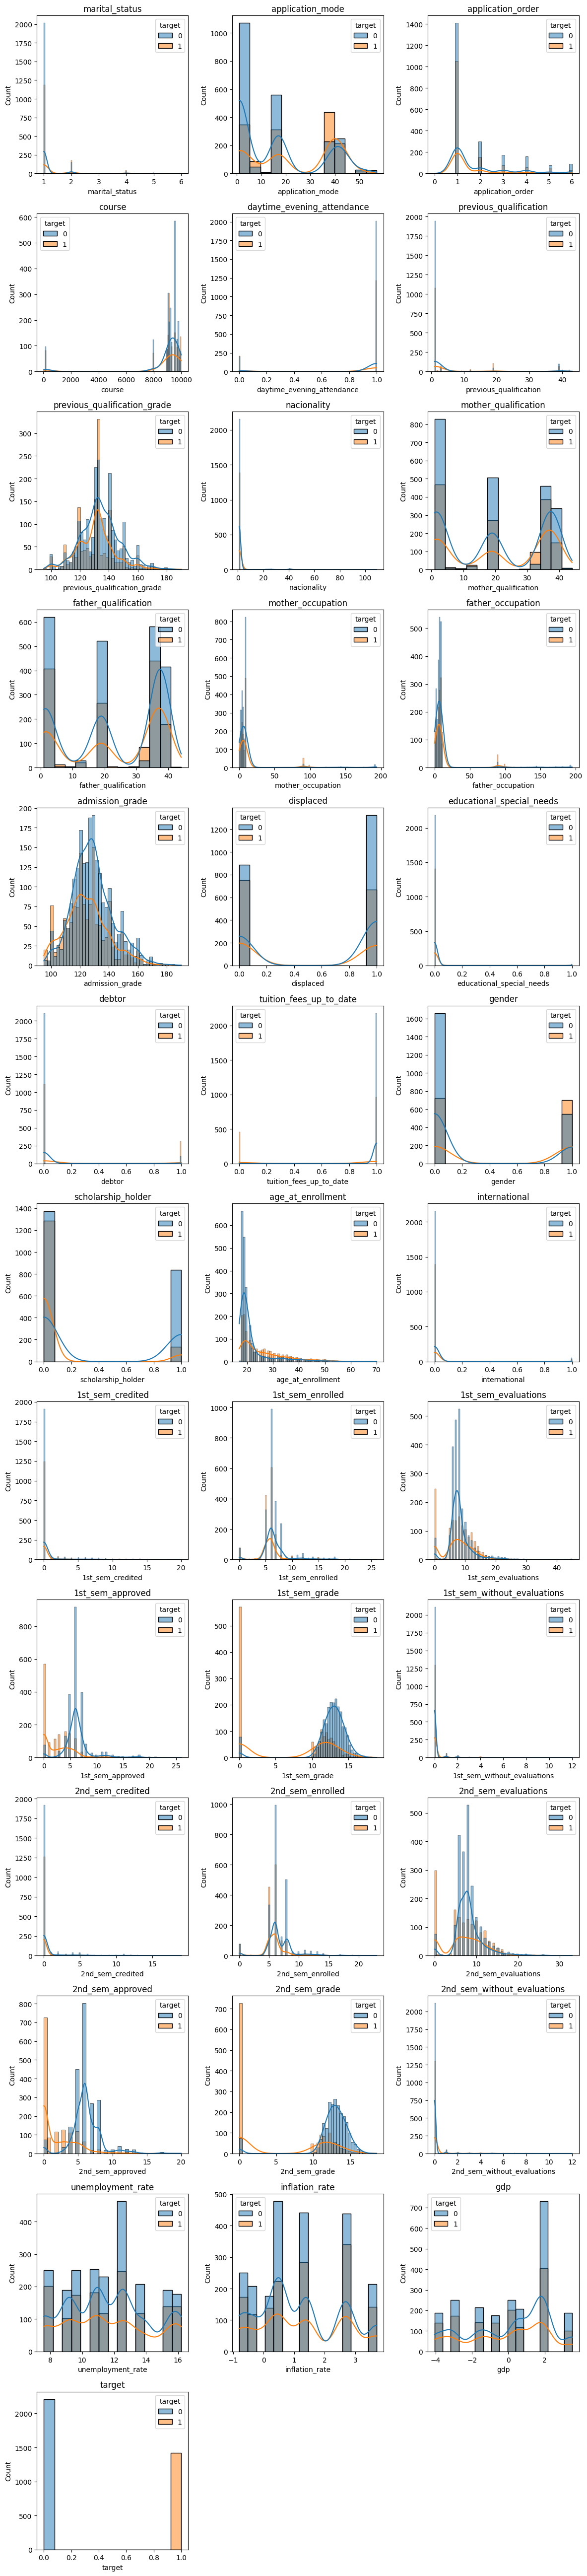

In [9]:
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sb.histplot(data=df, x=col, hue="target", kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: >

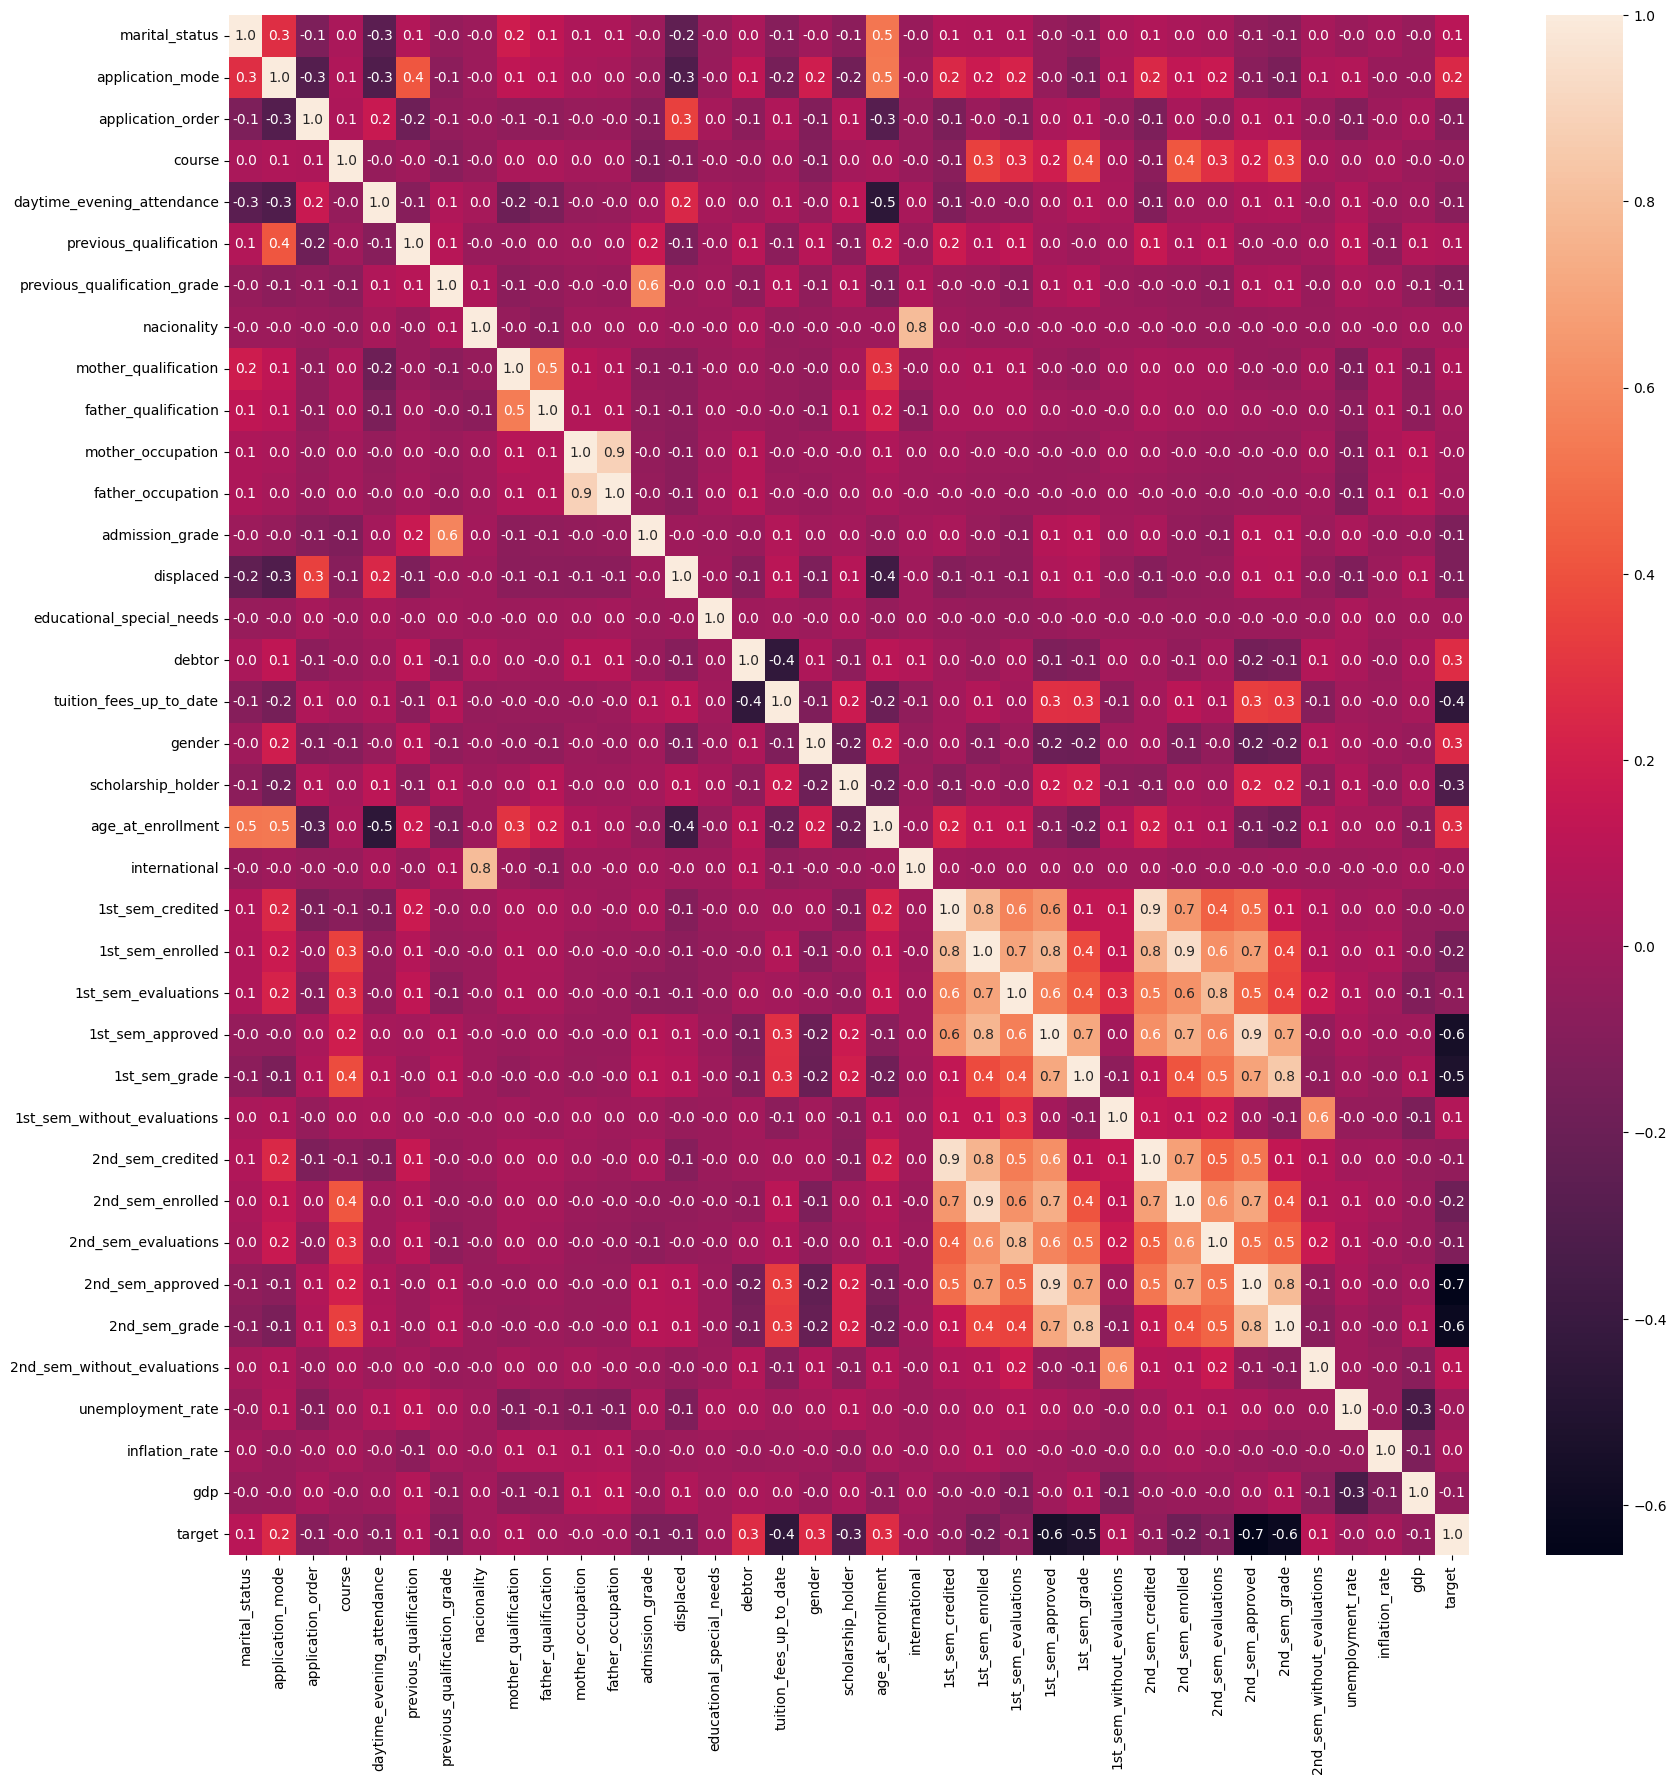

In [10]:
plt.figure(figsize=(20,20))
sb.heatmap(df.corr(), annot=True, fmt=".1f")
# df.corr()

In [11]:
from scipy.stats import pearsonr

data = []
for col in df.columns:
    if col != "target":
        corr = pearsonr(df[col], df["target"]).statistic.round(2)
    data.append((col, corr))

corr_df = pd.DataFrame(data, columns=["col", "corr"])
corr_df["corr_abs"] = abs(corr_df["corr"])
corr_df = corr_df.sort_values(by="corr_abs", ascending=False).reset_index(drop=True)
corr_df

,col,corr,corr_abs
0,2nd_sem_approved,-0.65,0.65
1,2nd_sem_grade,-0.61,0.61
2,1st_sem_approved,-0.55,0.55
3,1st_sem_grade,-0.52,0.52
4,tuition_fees_up_to_date,-0.44,0.44
5,scholarship_holder,-0.31,0.31
6,debtor,0.27,0.27
7,age_at_enrollment,0.27,0.27
8,gender,0.25,0.25
9,application_mode,0.24,0.24


<Axes: xlabel='corr', ylabel='col'>

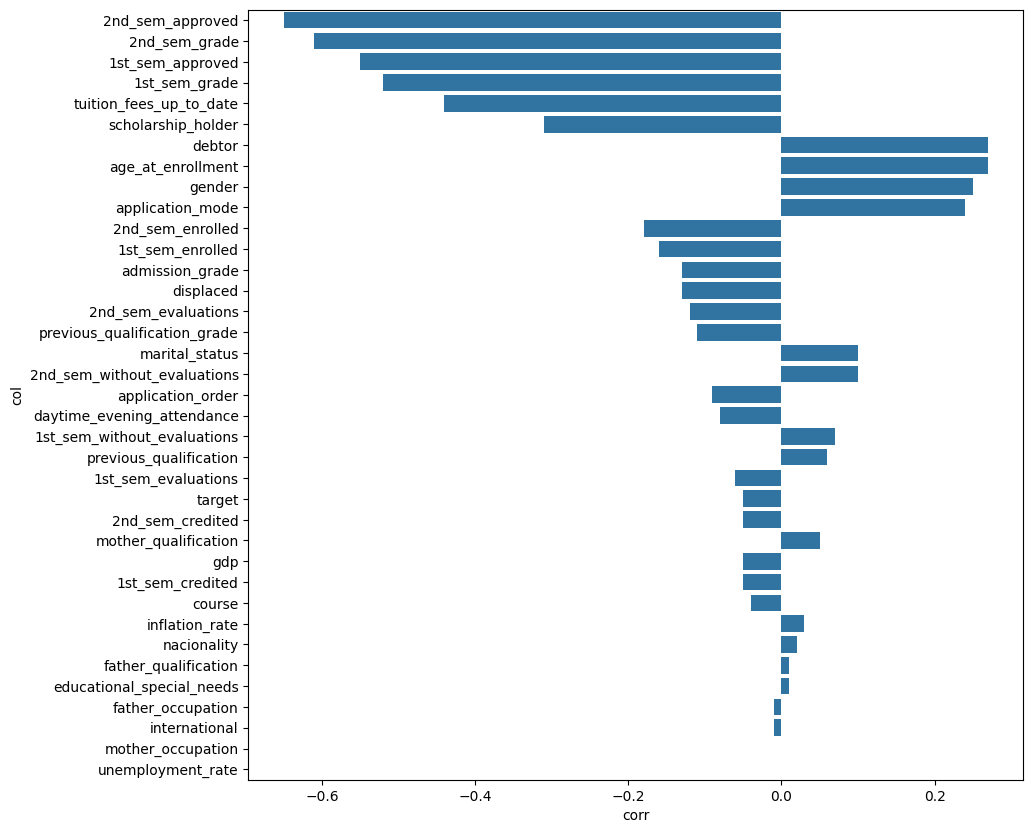

In [12]:
plt.figure(figsize=(10,10))
sb.barplot(data=corr_df, x="corr", y="col")

## Train test split

In [13]:
def xy_column_spit(df):
    x = df.drop("target", axis=1)
    y = df["target"]
    assert len(x) == len(df)
    assert len(y) == len(df)
    return x,y

TRAIN_SIZE = 0.85
TEST_SIZE = 0.15
assert(TRAIN_SIZE + TEST_SIZE == 1)

train, test = train_test_split(
    df, 
    train_size=TRAIN_SIZE,
    test_size=TEST_SIZE, 
    random_state=0,
    shuffle=True
)

train_x, train_y = xy_column_spit(train)
test_x, test_y = xy_column_spit(test)
print(len(train_x), len(test_x))

3085 545


## Dimensionality reduction exploration

[0.1808589  0.1035364  0.0592521  0.05337152 0.05300366 0.04760304
 0.04400703 0.04194623 0.03609765 0.03310955 0.03071202 0.02773249
 0.02716694 0.02554711 0.02378337 0.02254216 0.02158883 0.01999661
 0.01748069 0.0158761  0.01537561 0.01453616 0.01270213 0.01232167
 0.01119291 0.00973303 0.00847746 0.00634574 0.0054583  0.00503883
 0.00426738 0.00304706 0.00260875 0.0022988  0.00084644 0.00053733]


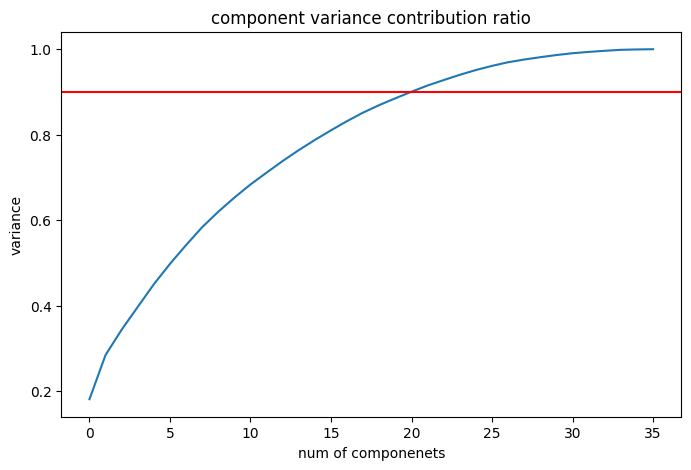

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_x_scaled = StandardScaler().fit(train_x).transform(train_x)
pca = PCA().fit(train_x_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(explained)
plt.xlabel('num of componenets')
plt.ylabel('variance')
plt.title('component variance contribution ratio')
plt.axhline(y=0.90, color='r')
plt.show()

> Based on this we see that 90% of the variance in the data is explained with 19 components so we will use that number.

## Baseline model

In [15]:
baseline = DummyClassifier(strategy="uniform", random_state=42)
baseline = baseline.fit(train_x, train_y)
preds = baseline.predict(test_x)
print("baseline")
print(classification_report(test_y, preds, zero_division=0))
print("fbeta", round(fbeta_score(test_y, preds, beta=FBETA_BETA),2))

baseline
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       314
           1       0.42      0.51      0.46       231

    accuracy                           0.49       545
   macro avg       0.50      0.50      0.49       545
weighted avg       0.51      0.49      0.50       545

fbeta 0.5


## Training

In [16]:
def fbeta_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return fbeta_score(y, preds, beta=2)

def train(
    train_x,
    train_y,
    create_pipeline, 
    param_grid, 
    scorer_fn,
    tune_threshold=False, 
    cv=5,
    n_jobs=5,
    show_param_grid=False
):
    import time
    start = time.time()
    
    # BUILD ESTIMATOR
    estimator = create_pipeline()

    # DEBUG
    if show_param_grid:
        print("Param grid")
        for k,v in param_grid.items():
            print(k,v)
        print("====")

    # GRID SEARCH AND FIT
    gs = GridSearchCV(
        estimator=estimator, 
        param_grid=param_grid, 
        scoring=scorer_fn,
        cv=cv, 
        refit=True,
        verbose=1,
        n_jobs=n_jobs
    ).fit(train_x,train_y)

    print("Best params")
    for p in gs.best_params_: 
        print(p, gs.best_params_[p])
    print("====")
    print("Best validation score:", gs.best_score_)
    print("Number of examples", len(train_x))
    print("Features", gs.best_estimator_[0].get_feature_names_out())
    
    # PLOT LEARNING CURVE
    common_params = {
        "X": train_x,
        "y": train_y,
        "train_sizes": np.linspace(0.05, 1.0, 5),
        "cv": cv,
        "score_type": "both",
        "n_jobs": n_jobs,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": scorer_fn,
    }
    LearningCurveDisplay.from_estimator(create_pipeline(gs.best_params_), **common_params)
    plt.show()
    T = None 
    
    # THRESHOLD TUNING
    if tune_threshold:
        print("tuning threshold..")
        preds = cross_val_predict(
            create_pipeline(gs.best_params_),
            train_x,
            train_y,
            cv=cv,
            method="predict_proba",
            n_jobs=n_jobs
        )
    
        pr = []
        for T in np.arange(0, 1, 0.02):
            p = (preds[:,1]>T).astype("int")
            precision = precision_score(train_y, p)
            recall = recall_score(train_y, p)
            f1 = f1_score(train_y, p)
            fbeta = fbeta_score(train_y, p, beta=2)
            pr.append((T, recall, precision, f1, fbeta))
        pr = pd.DataFrame(data=pr, columns=["threshold", "recall", "precision", "f1", "fbeta"])
        pr = pr.sort_values(by="recall")
        plt.plot(pr["recall"], pr["precision"])
        plt.show()
        pr = pr.sort_values(by=["fbeta", "recall"], ascending=False)
        print(pr[:10].round(3))

        T = pr.head(1)["threshold"].values[0]
        print(T)
        preds = cross_val_predict(
            create_pipeline(gs.best_params_),
            train_x,    
            train_y,
            cv=cv,
            method="predict_proba",
            n_jobs=n_jobs
        )
        preds = (preds[:,1]>T).astype("int")
        print(classification_report(train_y, preds))
        print("fbeta", fbeta_score(train_y, preds, beta=2))

    end = time.time()
    dur = end - start
    print("duration", round(dur, 3))
    return create_pipeline(gs.best_params_), T



In [17]:
models = {}

## Logistic classifier

### Model definition

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def extract_params(prefix: str, params: dict) -> dict:
    selected_params = {}
    prefix = prefix + "__"
    for (k, v) in params.items():
        if k.startswith(prefix):
            k = k.replace(prefix, "")
            selected_params[k] = v
    return selected_params

def logistic_sgd(pca=False):
    param_grid = {
        "clf__random_state": [42],
        "clf__penalty": [None, "l1", "l2"],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__max_iter": np.power(10, np.arange(3, 5)),
        "clf__class_weight": [
            {0:0.5, 1:1},
            {0:1, 1:2},
        ],
    }

    if pca:
        param_grid["pca__n_components"] = [19] # list(range(15, 30, 2))
    
    def create_pipeline(params={}):
        steps = []
        steps.append(("scaler", StandardScaler()))
        if pca: steps.append(("pca", PCA(**extract_params("pca", params))))
        steps.append(("clf", SGDClassifier(loss="log_loss", **extract_params("clf", params))))
        return  Pipeline(steps=steps)

    return (create_pipeline, param_grid, True)


### All features

Param grid
clf__random_state [42]
clf__penalty [None, 'l1', 'l2']
clf__alpha [0.0001, 0.001, 0.01]
clf__max_iter [ 1000 10000]
clf__class_weight [{0: 0.5, 1: 1}, {0: 1, 1: 2}]
====
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params
clf__alpha 0.001
clf__class_weight {0: 0.5, 1: 1}
clf__max_iter 1000
clf__penalty l2
clf__random_state 42
====
Best validation score: 0.8821165220037074
Number of examples 3085
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '1st_sem_without_evaluations' '2nd_sem_credite

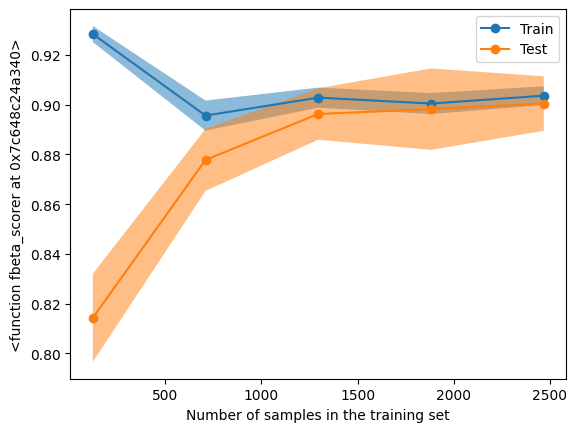

tuning threshold..


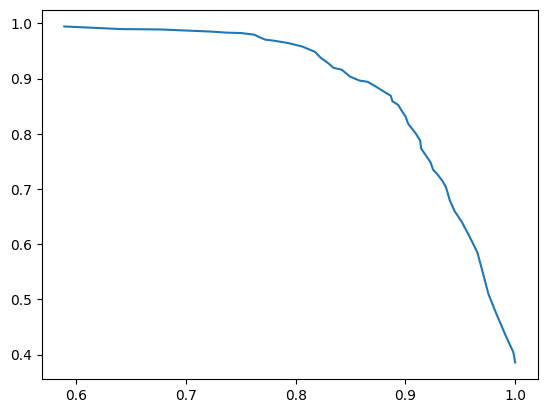

    threshold  recall  precision     f1  fbeta
22       0.44   0.900      0.832  0.864  0.885
19       0.38   0.909      0.801  0.852  0.885
18       0.36   0.913      0.788  0.846  0.885
23       0.46   0.897      0.839  0.867  0.885
24       0.48   0.893      0.852  0.872  0.885
20       0.40   0.905      0.812  0.856  0.885
21       0.42   0.903      0.818  0.858  0.884
26       0.52   0.887      0.869  0.878  0.883
25       0.50   0.888      0.859  0.873  0.882
17       0.34   0.914      0.773  0.838  0.882
0.44
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1895
           1       0.83      0.90      0.86      1190

    accuracy                           0.89      3085
   macro avg       0.88      0.89      0.89      3085
weighted avg       0.89      0.89      0.89      3085

fbeta 0.8854166666666666
duration 2.93


In [23]:
create_pipeline, param_grid, tune_threshold = logistic_sgd() 
model, T = train(
    train_x, 
    train_y, 
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["logistic"] = {"model": model, "T": T}

### PCA (19 components)

In [ ]:
create_pipeline, param_grid, tune_threshold = logistic_sgd(pca = True) 
model, T = train(
    train_x, 
    train_y, 
    create_pipeline,
    param_grid,
    fbeta_scorer,
    tune_threshold=True,
    show_param_grid=True
)

models["logistic_pca"] = {"model": model, "T": T}

## KNN

In [ ]:
# from models import knn
# create_pipeline, param_grid, tune_threshold = knn() 
# model, T = train(
#     train_x, 
#     train_y, 
#     create_pipeline,
#     param_grid,
#     fbeta_scorer,
#     tune_threshold=True,
#     show_param_grid=True
# )

## SVM

In [ ]:
# from models import svm
# create_pipeline, param_grid, tune_threshold = svm() 
# model, T = train(
#     train_x, 
#     train_y, 
#     create_pipeline,
#     param_grid,
#     fbeta_scorer,
#     tune_threshold=True,
#     show_param_grid=True
# )

## Eval

In [ ]:
# EVALUATE
def eval(model_info):
    model = model_info["model"]
    model = model.fit(train_x, train_y)
    if "T" in model_info:
        T = model_info["T"]
        preds = model.predict_proba(test_x)
        preds = (preds[:,1]>T).astype("int")
    else:
        preds = model.predict(test_x)
    # print(classification_report(test_y, preds))
    fbeta = fbeta_score(test_y, preds, beta=2)
    print("fbeta", fbeta)

for model in models:
    print(model)
    eval(models[model])